In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
num_per_class = 2000
image_size = 30

images = torch.zeros(num_per_class, 1, image_size, image_size)
labels = torch.zeros(num_per_class, 1)

for i in range(num_per_class):
    gaussian = np.random.randn(image_size, image_size)

    i_1 = np.random.choice(np.arange(2, 28))
    i_2 = np.random.choice(np.arange(2, 6))
    if np.random.randn() > 0:
        gaussian[i_1:i_1+i_2, ] = 1
    else:
        gaussian[:, i_1:i_1+i_2] = 1
        labels[i] = 1

    images[i, :, :, :] = torch.Tensor(gaussian).view(1, image_size, image_size)

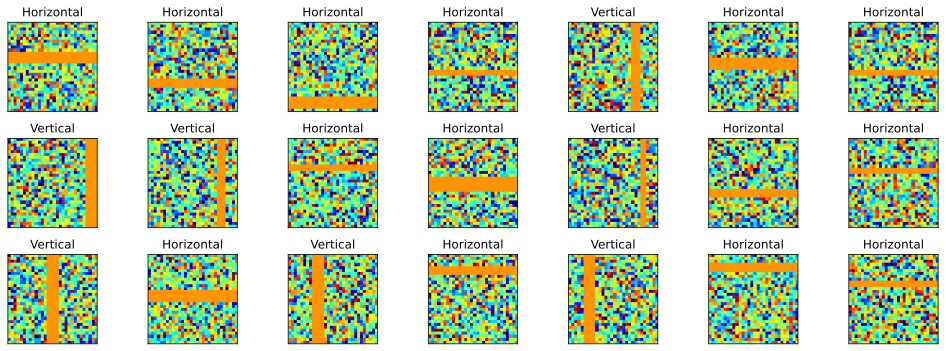

In [3]:
_, axis = plt.subplots(3,7,figsize=(14,5))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(num_per_class)
    gaussian = np.squeeze(images[pic, :, :])
    ax.imshow(gaussian, vmin=-2, vmax=2, cmap='jet', extent=[-4, 4, -4, 4], origin='upper')

    title = 'Horizontal' if labels[pic].item() == 0 else 'Vertical'
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout();

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=17)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
train_loader.dataset.tensors[0].shape

torch.Size([1600, 1, 30, 30])

In [6]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 7, 3, 1, 1)
            self.b_norm1 = nn.BatchNorm2d(7)
            # (30 + 2*1 - 3)/1 + 1 = 30/2 = 15
            
            self.conv2 = nn.Conv2d(7, 10, 3, 1, 1)
            self.b_norm2 = nn.BatchNorm2d(10)
            # (15 + 2*1 - 3)/1 + 1 = 15/3 = 5
            
            self.conv3 = nn.Conv2d(10, 15, 3, 1)
            self.b_norm3 = nn.BatchNorm2d(15)
            # (5-3)/1 + 1 = 3
            
            self.fc1 = nn.Linear(3*3*15, 50)
            
            self.fc2 = nn.Linear(50, 10)
            
            self.out = nn.Linear(10, 1)
        
        def forward(self, x):
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
        
            x = self.b_norm1(x)
            x = f.leaky_relu(x)
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 3)
        
            x = self.b_norm2(x)
            x = f.leaky_relu(x)
            
            x = self.conv3(x)
        
            x = self.b_norm3(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            
            x = self.fc2(x)
            x = f.leaky_relu(x)
            
            x = self.out(x)
            x = f.relu(x)
            
            return x
    
    cnn = CNN()
    
    loss_fun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-4)
    
    return cnn, loss_fun, optimizer

In [7]:
summary(model()[0].to(device), (1, 30, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 30, 30]              70
       BatchNorm2d-2            [-1, 7, 15, 15]              14
            Conv2d-3           [-1, 10, 15, 15]             640
       BatchNorm2d-4             [-1, 10, 5, 5]              20
            Conv2d-5             [-1, 15, 3, 3]           1,365
       BatchNorm2d-6             [-1, 15, 3, 3]              30
            Linear-7                   [-1, 50]           6,800
            Linear-8                   [-1, 10]             510
            Linear-9                    [-1, 1]              11
Total params: 9,460
Trainable params: 9,460
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.04
Estimated Total Size (MB): 0.12
-----------------------------------------------

In [8]:
x, y = next(iter(test_loader))

cnn = model()[0]

print(x.shape, y.shape)
print(cnn(x).shape)

torch.Size([400, 1, 30, 30]) torch.Size([400, 1])
torch.Size([400, 1])


In [9]:
def train_model():
    
    num_epochs = 10
    
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    cnn, loss_fun, optimizer = model()
    cnn.to(device)
    
    for epoch in range(num_epochs):
        
        cnn.train()
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            y = y.cpu()
            y_hat = y_hat.cpu()
            
            batch_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
        
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        cnn.eval()
        x, y = next(iter(test_loader))
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

        y = y.cpu()
        y_hat = y_hat.cpu()
        test_loss.append(loss.item())
        test_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
        
    return train_acc, train_loss, test_acc, test_loss, cnn

In [10]:
train_acc, train_loss, test_acc, test_loss, cnn = train_model()

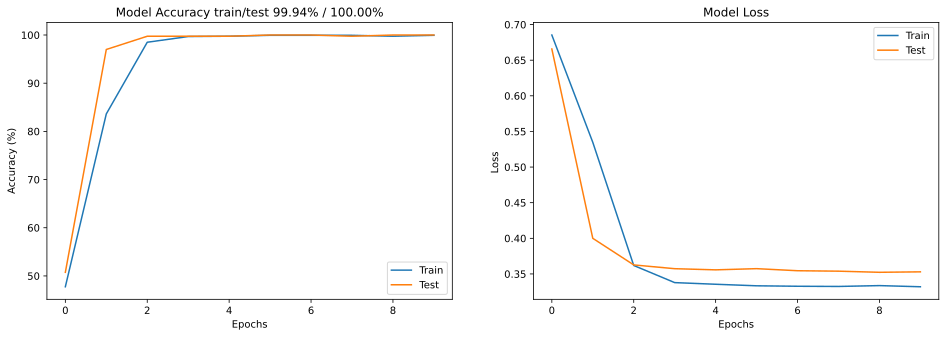

In [11]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_acc, "-", label="Train")
axis[0].plot(test_acc, "-", label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracy (%)")
axis[0].set_title(f"Model Accuracy train/test {train_acc[-1]:0.2f}% / {test_acc[-1]:0.2f}%")
axis[0].legend()

axis[1].plot(train_loss, "-", label="Train")
axis[1].plot(test_loss, "-", label="Test")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Loss ")
axis[1].set_title(f"Model Loss")
axis[1].legend();